In [1]:
# PR: https://github.com/pytorch/pytorch/pull/33753

# GPU: RTX 2070 Super

def main(device):
    import torch 
    print(torch.__version__)
    print()
    
    dtype = torch.float

    for N in [1<<4, 1<<6, 1<<8, 1<<10, 1<<12, 1<<14]:
        for D in [1<<0, 1<<4, 1<<8, 1<<12]:
            for K in [1<<0, 1<<4, 1<<8, 1<<12]: 
                torch.cuda.empty_cache() # this solves the problem where pytorch GPU tensor is not freed in Jupyter
                print(f"Tensor size ({N}, {D}), indices size {K}")
                
                a = torch.randn(N, D, device=device, dtype=dtype, requires_grad=True)
                indices_x = torch.randint(0, N, (K, ), device="cpu", dtype=torch.long)
                indices_y = torch.randint(0, D, (K, ), device="cpu", dtype=torch.long)
                values = torch.ones((K, ), device=device, dtype=dtype)

                torch.cuda.synchronize()

                def func_forward(): 
                    torch.cuda.synchronize()
                    a.index_put((indices_x, indices_y), values, accumulate=True)
                    torch.cuda.synchronize()

                print("forward: ")
                %timeit func_forward()

                b = a.index_put((indices_x, indices_y), values, accumulate=True).sum()
                torch.cuda.synchronize()

                def func_backward():
                    torch.cuda.synchronize()
                    b.backward(retain_graph=True)    
                    torch.cuda.synchronize()

                print("backward: ")
                %timeit func_backward()

                print()

## Before

In [2]:
main("cuda:0")

1.5.0a0+4460c8b

Tensor size (16, 1), indices size 1
forward: 
211 µs ± 1.56 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
174 µs ± 2.91 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 16
forward: 
221 µs ± 5.65 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
175 µs ± 2.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 256
forward: 
233 µs ± 3.37 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
191 µs ± 12.9 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 4096
forward: 
445 µs ± 18.3 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
175 µs ± 2.28 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 16), indices size 1
forward: 
221 µs ± 8.03 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
178 µs ± 3.96 µs per loop (mean ± st

221 µs ± 2.18 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
178 µs ± 2.08 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 16
forward: 
229 µs ± 24.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
173 µs ± 4.8 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 256
forward: 
238 µs ± 14.5 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
175 µs ± 2.61 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 4096
forward: 
363 µs ± 31.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
189 µs ± 8.16 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 4096), indices size 1
forward: 
219 µs ± 346 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
166 µs ± 2.65 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (2

210 µs ± 195 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
172 µs ± 1.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 16
forward: 
232 µs ± 23 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
176 µs ± 6.55 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 256
forward: 
233 µs ± 1.59 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
172 µs ± 2.42 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 4096
forward: 
361 µs ± 26.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
166 µs ± 6.76 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 16), indices size 1
forward: 
219 µs ± 120 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
162 µs ± 102 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (1638

## After

In [2]:
main("cuda:0")

1.5.0a0+2f8ed14

Tensor size (16, 1), indices size 1
forward: 
212 µs ± 447 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
172 µs ± 424 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 16
forward: 
233 µs ± 25.7 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
170 µs ± 1.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 256
forward: 
241 µs ± 28.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
167 µs ± 1.47 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 1), indices size 4096
forward: 
434 µs ± 12.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
156 µs ± 11.5 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16, 16), indices size 1
forward: 
228 µs ± 26.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
166 µs ± 2.78 µs per loop (mean ± std.

216 µs ± 16.6 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
165 µs ± 8.71 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 16
forward: 
232 µs ± 26.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
173 µs ± 1.83 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 256
forward: 
238 µs ± 22.9 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
165 µs ± 4.51 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 256), indices size 4096
forward: 
352 µs ± 21 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
164 µs ± 830 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (256, 4096), indices size 1
forward: 
229 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
169 µs ± 4.23 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (25

206 µs ± 223 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
167 µs ± 614 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 16
forward: 
229 µs ± 27.1 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
171 µs ± 594 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 256
forward: 
239 µs ± 23.2 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
171 µs ± 1.02 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 1), indices size 4096
forward: 
349 µs ± 495 ns per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
171 µs ± 1.79 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (16384, 16), indices size 1
forward: 
233 µs ± 27.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
backward: 
173 µs ± 1.1 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)

Tensor size (1638

## Compare

In [13]:
# After manually copying the outputs to before.txt and after.txt 

import numpy as np 
import seaborn as sns

with open('before.txt', 'r') as f: 
    before = f.readlines() 
with open('after.txt', 'r') as f: 
    after = f.readlines() 

def parse(lines):
    d_fwd_time = {}
    d_back_time = {}
    
    for i in range(0, len(lines), 6): 
        line = lines[i] 
        
        tensor_size = (
            int(line[line.index('(') + 1 : line.index(',')]), 
            int(line[line.index(',') + 1: line.index(')')])
        )
        indices_size = int(line[line.rfind(' ') + 1 : ])
        
        key = (tensor_size[0], tensor_size[1], indices_size)
        
        def parse_time(linex):
            space = linex.index(' ')
            t = float(linex[: space])
            if linex[space + 1] == u'n': 
                t /= 1000 
            elif linex[space + 1] == u'µ':
                pass
            elif linex[space + 1] == u'm': 
                t *= 1000
            
            return t
            
        fwd_time = parse_time(lines[i+2])
        back_time = parse_time(lines[i+4])
    
        d_fwd_time[key] = fwd_time 
        d_back_time[key] = back_time
        
    return (d_fwd_time, d_back_time)   

d_fwd_before, d_back_before = parse(before)
d_fwd_after, d_back_after = parse(after)

def compare(d_before, d_after, s): 
    print('compare for', s)
    print()
    print('tensor size\tindices\tbefore\tafter\tregression')
    
    diffs = []
    for key in d_before: 
        t_before = d_before[key] 
        t_after = d_after[key] 
        
        diffs.append(t_after - t_before)
        
        if (t_after - t_before) / t_before > 0.05: 
            print(f"{key[0]:6} {key[1]:6} {key[2]:6}", t_before, t_after, 
                  f"{(t_after - t_before) / t_before * 100.0 : .1f}%", sep='\t')
    
    print()
    print('t_after - t_before:')
    print('mean =', np.mean(diffs))
    print('median =', np.median(diffs))
    print('max =', np.max(diffs))
    print('min =', np.min(diffs))
    
    sns.distplot(diffs)

compare for forward

tensor size	indices	before	after	regression
    16      1     16	221.0	233.0	 5.4%
    64     16      1	219.0	231.0	 5.5%
    64    256      1	219.0	230.0	 5.0%
  1024      1     16	221.0	233.0	 5.4%
 16384     16      1	219.0	233.0	 6.4%

t_after - t_before:
mean = -0.34375
median = -1.0
max = 14.0
min = -16.0


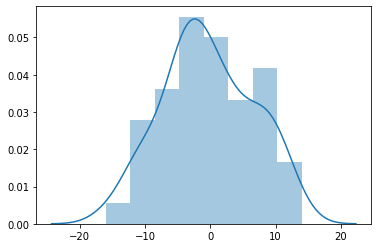

In [14]:
compare(d_fwd_before, d_fwd_after, 'forward')

compare for backward

tensor size	indices	before	after	regression
    16     16    256	157.0	169.0	 7.6%
    64   4096    256	158.0	170.0	 7.6%
   256     16    256	169.0	180.0	 6.5%
   256   4096   4096	164.0	173.0	 5.5%
  4096     16    256	161.0	175.0	 8.7%
  4096     16   4096	158.0	170.0	 7.6%
  4096    256      1	158.0	167.0	 5.7%
  4096    256     16	159.0	170.0	 6.9%
  4096    256    256	158.0	167.0	 5.7%
  4096    256   4096	157.0	168.0	 7.0%
 16384     16      1	162.0	173.0	 6.8%

t_after - t_before:
mean = -2.6041666666666665
median = -4.0
max = 40.0
min = -25.0


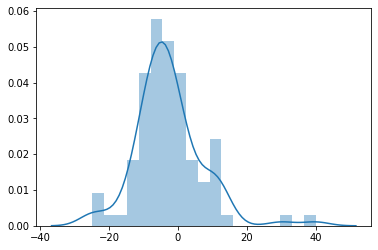

In [15]:
compare(d_back_before, d_back_after, 'backward')